"""
Date: 2022-10-01
Author: Martin Loza
Name: Import bin information from mcool files
"""

On this notebook I will test the mcool files and the cooltools package to import the bin information from them


In [131]:
import cooler
import matplotlib.pyplot as plt
import pandas as pd
import h5py

#Global variables
date = 231211
seed = 777
in_dir = "/Volumes/MARTIN_LOZA/Projects/HK_Interactions/Data/HiC/SRA/mcool/"
our_dir = "~/Documents/Projects/HK_Interactions/Analysis/2023_12_12/Results/"

In [132]:
#test for importing cooler
#cooler.fileops.list_coolers(in_dir + "GM12878-HindIII-allReps-filtered.mcool" )
res = 10000
tcooler = cooler.Cooler(in_dir + "GM12878-HindIII-allReps-filtered.mcool::resolutions/" + str(res))
# tcooler = cooler.Cooler(in_dir + "K562-HindIII-allReps-filtered.mcool::resolutions/" + str(res))

I have been reading the documentation in internet of cooler [https://buildmedia.readthedocs.org/media/pdf/cooler/latest/cooler.pdf]. Though, I still don't understand everything perfectly. This is what I know now. 

Cool files includes the bin, and pixel information. After normalizing with ICE, a weight column is stored in the bin data. Using this weight we can normalize the counts in bins by multiplying the bin by the appropiate weights. For example bin1 = 0, bin2 = 1, counts = X, then the normalize will be norm=counts * weight(bin0) * weight(bin1).

This can be done with the cool package by loading the bins with the parameter "balance" to true. Also we can load the bins as bedpe files with the parameter join = true. 

In [133]:
#exploring the bins
tcooler.bins()[:10]
#they have weight normalization column

,chrom,start,end,weight
0,chr1,0,100000,NaN
1,chr1,100000,200000,NaN
2,chr1,200000,300000,NaN
3,chr1,300000,400000,NaN
4,chr1,400000,500000,NaN
5,chr1,500000,600000,NaN
6,chr1,600000,700000,0.001409
7,chr1,700000,800000,NaN
8,chr1,800000,900000,0.012352
9,chr1,900000,1000000,0.013889


In [134]:
#exploring the pixels
tcooler.pixels()[:10]
#they are not normalized, so we need to normalize them using the weight column

,bin1_id,bin2_id,count
0,0,0,14
1,0,6,2
2,0,125,2
3,0,325,2
4,0,521,2
5,0,608,2
6,0,1022,2
7,0,2358,2
8,0,2437,2
9,0,2480,2


In [135]:
#exploring the matrix balance. This uses the weight column to normalize the pixels. 
#We could use this matrix to get a average matrix for all the cell types.
tcooler.matrix(balance=True, as_pixels=True, join=True)[1:3,5:10]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced
0,chr1,100000,200000,chr1,500000,600000,4,NaN
1,chr1,200000,300000,chr1,500000,600000,2,NaN
2,chr1,200000,300000,chr1,700000,800000,2,NaN


Let's analyse the matrix information in one cell type. In this test, I would like to ignore the inter-chromosome interactions.

In [136]:
#lets get the matrix for a specific cell type
matrix = tcooler.matrix(balance=True, as_pixels=True, join=True)[:]
matrix = pd.DataFrame(matrix)

In [137]:
#inter-chromosomal interactions
matrix[matrix["chrom1"] != matrix["chrom2"]]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced
10,chr1,0,100000,chr2,1800000,1900000,2,NaN
11,chr1,0,100000,chr2,38400000,38500000,2,NaN
12,chr1,0,100000,chr2,63500000,63600000,2,NaN
13,chr1,0,100000,chr2,72200000,72300000,2,NaN
14,chr1,0,100000,chr2,84400000,84500000,2,NaN
...,...,...,...,...,...,...,...,...
36579142,chr22,50700000,50800000,chrX,155000000,155100000,2,0.000227
36579143,chr22,50700000,50800000,chrX,155800000,155900000,2,0.000255
36579144,chr22,50700000,50800000,chrX,155900000,156000000,2,0.000224
36579145,chr22,50700000,50800000,chrX,156000000,156040895,2,NaN


We can observe many inter-chromosome interactions. For how, let's remove them

In [138]:
#remove inter chromosomal interactions
matrix = matrix[matrix["chrom1"] == matrix["chrom2"]]
#show inter-choromosomal interaction
matrix[matrix["chrom1"] != matrix["chrom2"]]

,chrom1,start1,end1,chrom2,start2,end2,count,balanced


No more inter-chromosomal interactions. Let's continue

In [139]:
chromosome_1["balanced"]

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
              ...   
10930855    0.089317
10930856    0.047680
10934278    0.255587
10934279    0.192645
10940213    0.512037
Name: balanced, Length: 1420210, dtype: float64

In [140]:
# matrix.to_csv('matrix.tsv', sep='\t', index=False)


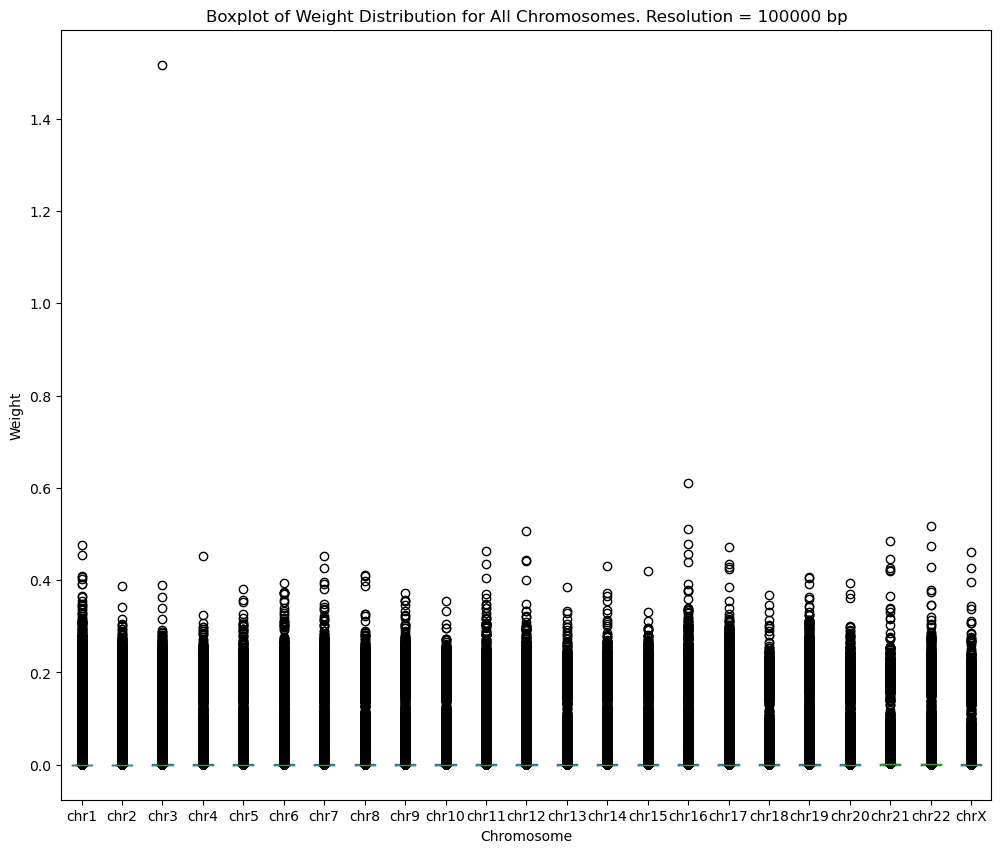

In [141]:
# Get the unique chromosomes in the matrix dataframe
chromosomes = matrix["chrom1"].unique()

# Create an empty list to store the balanced values for each chromosome
balanced_list = []

# Iterate over each chromosome
for chromosome in chromosomes:
    # Get the balanced values for the current chromosome
    balanced_values = matrix[matrix["chrom1"] == chromosome]["balanced"]
    
    # Append the balanced values to the list
    balanced_list.append(balanced_values)

# Convert the list to a data frame
balanced_df = pd.DataFrame(balanced_list, index=chromosomes).T

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 10))

# Create the boxplot
balanced_df.plot.box(ax=ax)
plt.title("Boxplot of Weight Distribution for All Chromosomes. Resolution = " + str(res) + " bp")
plt.xlabel("Chromosome")
plt.ylabel("Weight")
plt.show()


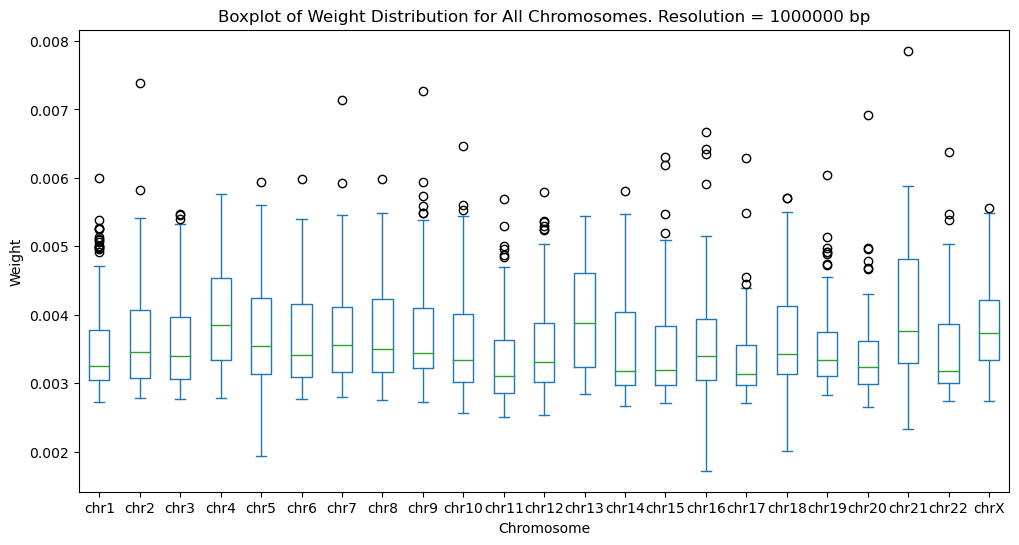

In [74]:
# Get the unique chromosomes in the tcooler object
chromosomes = tcooler.chromnames

# Create an empty list to store the weights for each chromosome
weights_list = []

# Iterate over each chromosome
for chromosome in chromosomes:
    # Get the weight column for the current chromosome
    weights = tcooler.bins().fetch(chromosome)['weight']
    
    # Append the weights to the list
    weights_list.append(weights)

# Convert the weights list to a data frame
weights_df = pd.DataFrame(weights_list, index=chromosomes).T

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplot
weights_df.plot.box(ax=ax)
plt.title("Boxplot of Weight Distribution for All Chromosomes. Resolution = " + str(res) + " bp")
plt.xlabel("Chromosome")
plt.ylabel("Weight")
plt.show()

In [76]:
# Open mcool file
mcool_file = h5py.File(in_dir + "GM12878-HindIII-allReps-filtered.mcool")
# Get the available resolutions in the mcool file
resolutions = tcooler.resolutions()

# Iterate over each resolution
for res in resolutions:
    # Get the cooler object for the current resolution
    tcooler_res = cooler.Cooler(in_dir + "GM12878-HindIII-allReps-filtered.mcool::resolutions/" + str(res))
    
    # Get the unique chromosomes in the tcooler_res object
    chromosomes = tcooler_res.chromnames
    
    # Create an empty list to store the weights for each chromosome
    weights_list = []
    
    # Iterate over each chromosome
    for chromosome in chromosomes:
        # Get the weight column for the current chromosome
        weights = tcooler_res.bins().fetch(chromosome)['weight']
        
        # Append the weights to the list
        weights_list.append(weights)
    
    # Convert the weights list to a data frame
    weights_df = pd.DataFrame(weights_list, index=chromosomes).T
    
    # Set the figure size
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create the boxplot
    weights_df.plot.box(ax=ax)
    plt.title("Boxplot of Weight Distribution for All Chromosomes. Resolution = " + str(res) + " bp")
    plt.xlabel("Chromosome")
    plt.ylabel("Weight")
    plt.show()


NameError: name 'h5py' is not defined